In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip drive/"My Drive"/trainm.zip

Archive:  drive/My Drive/trainm.zip
   creating: trainm/
  inflating: __MACOSX/._trainm       
   creating: trainm/fight/
  inflating: __MACOSX/trainm/._fight  
  inflating: trainm/.DS_Store        
  inflating: __MACOSX/trainm/._.DS_Store  
  inflating: trainm/LICENSE          
  inflating: __MACOSX/trainm/._LICENSE  
   creating: trainm/noFight/
  inflating: __MACOSX/trainm/._noFight  
  inflating: trainm/README.md        
  inflating: __MACOSX/trainm/._README.md  
  inflating: trainm/_train_labels_train.npy  
  inflating: trainm/_train_fights_train.npy  
  inflating: trainm/videos.txt       
  inflating: __MACOSX/trainm/._videos.txt  
  inflating: trainm/fight/fi003.mp4  
  inflating: __MACOSX/trainm/fight/._fi003.mp4  
  inflating: trainm/fight/fi017.mp4  
  inflating: __MACOSX/trainm/fight/._fi017.mp4  
  inflating: trainm/fight/fi016.mp4  
  inflating: __MACOSX/trainm/fight/._fi016.mp4  
  inflating: trainm/fight/fi002.mp4  
  inflating: __MACOSX/trainm/fight/._fi002.mp4  
  infl

In [5]:
from __future__ import absolute_import
from __future__  import division
from __future__ import print_function
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from numpy import save
from numpy import load
import copy
dataset_size = 300
nbr_frame = 20
img_width = 260
img_height = 220
IMG_SIZE = (img_width, img_height)
fights_train = np.zeros((dataset_size, nbr_frame, img_width, img_height, 3), dtype=np.float32)
fights_val = fights_train
labels_train = np.empty(dataset_size, dtype=np.int_)
labels_vals = np.empty(dataset_size, dtype=np.int_)
def capture(filename):
    frames = np.zeros((nbr_frame, img_width, img_height, 3), dtype=np.float32)
    i = 0
    vc = cv2.VideoCapture(filename)
    while i < nbr_frame:
        if vc.isOpened():
            rval , frame = vc.read()
        else:
            print('unreadable '+filename)
        #frm = cv2.resize(frame,(200,200))
        #print(' ' + str(i) + ' ' + filename + ' ')
        try:
            frame.shape
        except:
            print(' ' + str(i) + ' ' + filename + ' ')
        frm = resize(frame,(img_width, img_height, 3))
        frm = np.expand_dims(frm,axis=0)
        if(np.max(frm)>1):
            frm = frm/255.0
        frames[i][:] = frm
        i +=1
        #print(frame)
    return frames

def cut_save(main_dir, mod):
    i = 0
    #fights_val = np.zeros((399, 40, 200, 200, 3), dtype=np.float32)
    #labels_val = ''
    #noFights = np.zeros((599, 42, 200, 200, 3), dtype=np.float)
    fights_train_dest = main_dir+'_'+mod+'_fights_train'+'.npy'
    labels_train_dest = main_dir+'_'+mod+'_labels_train'+'.npy'
    if mod == 'train':
        if (os.path.exists(fights_train_dest) &
            os.path.exists(labels_train_dest)):
            print('loading train arrays')
            fights_train_ = load(fights_train_dest)
            labels_train_ = load(labels_train_dest)
            fights_train[:] = fights_train_
            labels_train[:] = labels_train_
        else:
            print('retrieving train arrays')
            for x in os.listdir(main_dir):
                td = main_dir+x+'/'
                if os.path.isdir(td):
                    #for y in os.listdir(main_dir+x+'/'):
                        #print(y)
                    for file in os.listdir(td):
                        fl = os.path.join(td, file)
                        videos = capture(fl)
                        if mod == 'train':
                            fights_train[i][:][:] = videos
                            if x =='fight':
                                labels_train[i]=1
                            else:
                                labels_train[i]=0
                        elif mod =='test':
                            fights_test[i][:][:] = videos
                            if x =='fight':
                                labels_test[i]=1
                            else:
                                labels_test[i]=0
                        elif mod =='val':
                            fights_val[i][:][:] = videos
                            if x =='fight':
                                labels_vals[i]=1
                            else:
                                labels_vals[i]=0
                        i +=1
            if mod == 'train':
                print('saving train arrays')
                save(main_dir+'_'+mod+'_fights_train'+'.npy', fights_train)
                save(main_dir+'_'+mod+'_labels_train'+'.npy', labels_train)
cut_save('./trainm/',"train")

retrieving train arrays
saving train arrays


In [6]:
from sklearn.model_selection import train_test_split
X_train, fights_test, y_train, labels_test = train_test_split(fights_train,labels_train, test_size=0.26, random_state=42)

In [ ]:
#cut_save('./testm/',"test")
#plt.imshow(fights_test[19][5])
#plt.show()

In [7]:
layers = tf.keras.layers
models = tf.keras.models
losses = tf.keras.losses
optimizers = tf.keras.optimizers
metrics = tf.keras.metrics
utils = tf.keras.utils
callbacks = tf.keras.callbacks
layers = tf.keras.layers
models = tf.keras.models
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
losses = tf.keras.losses
optimizers = tf.keras.optimizers
metrics = tf.keras.metrics
utils = tf.keras.utils
callbacks = tf.keras.callbacks

plot_model = tf.keras.utils.plot_model

In [17]:
y_train = utils.to_categorical(labels_train)
y_test = utils.to_categorical(labels_test)
class AccuracyHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []
        self.loss = []
        self.val_loss = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

history = AccuracyHistory()
earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=8,min_delta=1e-5, verbose=0, mode='min')
mcp_save = callbacks.ModelCheckpoint('fights.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = callbacks.ReduceLROnPlateau(monitor='val_loss',patience=1, verbose=2,factor=0.5,min_lr=0.0000001)


In [18]:
np.random.seed(1234)
num_classes = 2

#vg19 = tf.keras.applications.vgg19.VGG19
#base_model = vg19(include_top=False,weights='imagenet',input_shape=(img_width, img_height,3))
base_model = tf.keras.applications.ResNet50V2(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=IMG_SIZE + (3,), pooling=None
)
# Freeze the layers except the last 4 layers
for layer in base_model.layers:
    layer.trainable = False
# Check the trainable status of the individual layers
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 260, 220, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 266, 226, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 130, 110, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 132, 112, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [32]:
num_classes = 2

cnn = models.Sequential()
cnn.add(base_model)
#cnn.add(layers.Flatten())
cnn.add(layers.GlobalAveragePooling2D())
#cnn.add(layers.Dense(1024, activation=tf.nn.relu))
#cnn.add(layers.Dropout(0.2))
#cnn.add(layers.Dense(10024, activation=tf.nn.sigmoid))
cnn.add(layers.Dropout(0.2))
base_model.trainable = False

# define LSTM model
model = models.Sequential()

model.add(layers.TimeDistributed(cnn, input_shape=(nbr_frame, img_width, img_height, 3)))
model.add(layers.LSTM(nbr_frame, return_sequences=True))

#model.add(layers.Dense(num_classes, activation="sigmoid"))
#model.add(layers.Dropout(0.3))

model.add(layers.TimeDistributed(layers.Dense(nbr_frame, activation='relu')))
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling1D(name="globale"))

'''
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.24))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
'''
model.add(layers.Dense(400, activation='relu', name="filter"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='sigmoid', name="filter2"))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(num_classes, activation="sigmoid", name="last"))
# lr=0.0005,
adam = optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#model.load_weights('mamon98777.hdf5')
rms = optimizers.RMSprop()
#model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])

metrics = [tf.keras.metrics.CategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.CategoricalCrossentropy()

model.compile(
    loss=loss,
    optimizer= rms,
    metrics=metrics
)

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_22 (TimeD  (None, 20, 2048)          23564800  
 istributed)                                                     
                                                                 
 lstm_11 (LSTM)              (None, 20, 20)            165520    
                                                                 
 time_distributed_23 (TimeD  (None, 20, 20)            420       
 istributed)                                                     
                                                                 
 flatten_11 (Flatten)        (None, 400)               0         
                                                                 
 filter (Dense)              (None, 400)               160400    
                                                                 
 dropout_21 (Dropout)        (None, 400)             

In [34]:
batch_size = 10
epochs = 16

from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("started at =", current_time)
import time
millis = int(round(time.time() * 1000))
class MemoryPrintingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      gpu_dict = tf.config.experimental.get_memory_info('GPU:0')
      tf.print('\n GPU memory details [current: {} gb, peak: {} gb]'.format(
          float(gpu_dict['current']) / (1024 ** 3),
          float(gpu_dict['peak']) / (1024 ** 3)))

model.fit(fights_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
      #    verbose=1,
          validation_data=(fights_test, y_test),callbacks=[earlyStopping, mcp_save, reduce_lr_loss,history])

#0.8995 4

started at = 18:38:59
Epoch 1/16
30/30 [==============================] - 124s 4s/step - loss: 0.7228 - accuracy: 0.5100 - val_loss: 0.6788 - val_accuracy: 0.6026 - lr: 0.0010
Epoch 2/16
30/30 [==============================] - 115s 4s/step - loss: 0.6295 - accuracy: 0.6467 - val_loss: 0.5571 - val_accuracy: 0.7051 - lr: 0.0010
Epoch 3/16
30/30 [==============================] - ETA: 0s - loss: 0.5582 - accuracy: 0.7267
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
30/30 [==============================] - 115s 4s/step - loss: 0.5582 - accuracy: 0.7267 - val_loss: 0.5790 - val_accuracy: 0.6795 - lr: 0.0010
Epoch 4/16
30/30 [==============================] - 116s 4s/step - loss: 0.4266 - accuracy: 0.8067 - val_loss: 0.3883 - val_accuracy: 0.8077 - lr: 5.0000e-04
Epoch 5/16
30/30 [==============================] - 117s 4s/step - loss: 0.3559 - accuracy: 0.8233 - val_loss: 0.2991 - val_accuracy: 0.8462 - lr: 5.0000e-04
Epoch 6/16
30/30 [=======================

In [ ]:
model.save("fights.keras")

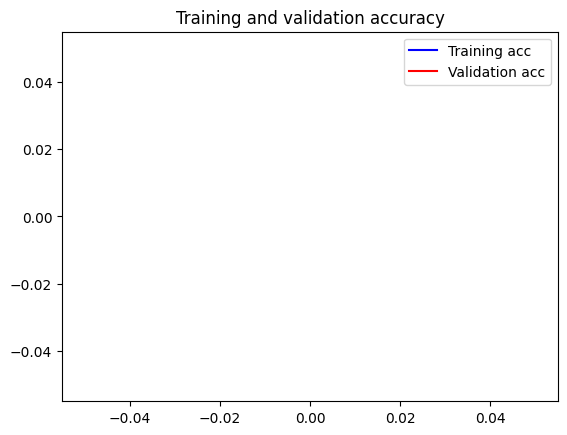

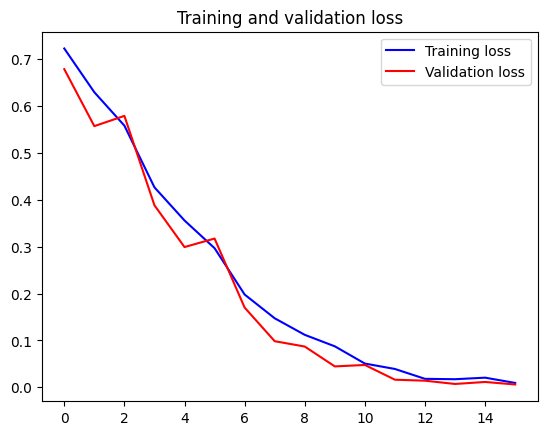

In [35]:
acc = history.acc
val_acc = history.val_acc
loss = history.loss
val_loss = history.val_loss
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
score = model.evaluate(fights_test, y_test, batch_size=3)
score

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [ ]:
Y_pred = model.predict(fights_test , batch_size=1)

In [ ]:
yprd = Y_pred > 0.5
yprd

In [ ]:
ypredicted = []
for zero,one in yprd:
    if zero == True:
        ypredicted.append(0)
    else:
        ypredicted.append(1)

In [ ]:
ypredicted

In [ ]:
y_test

In [ ]:
y = []

for zero,one in y_test:
    if zero == True:
        y.append(0)
    else:
        y.append(1)

In [ ]:
confusion = confusion_matrix(y,ypredicted)
confusion.shape

In [ ]:
print_confusion_matrix(confusion, [0,1], figsize = (30,15), fontsize=16)

In [ ]:
print('Classification Report')
print(classification_report(y, ypredicted, target_names=['no-violance','violance']))